<a href="https://colab.research.google.com/github/ali-rabiee/Brain-Signal-Analysis-Topomaps/blob/main/BrainSignalProcessing_Topomaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
!pip install numpy matplotlib mne scipy

In [ ]:
import zipfile
import mne
import warnings
warnings.filterwarnings("ignore")

# Specify the path to the ZIP file
zip_file_path = 'HW1_Materials.zip'

# Open the ZIP file in read mode
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the ZIP file into the directory
    zip_ref.extractall()

In [ ]:
import pandas as pd
from scipy.io import loadmat
import numpy as np

# Load electrode locations
elec_df = pd.read_csv('HW1_Materials/eloc64C2.txt', sep='\t', header=None, names=['Index', 'Angle', 'Radius', 'Label'])
elec_df['X'] = elec_df['Radius'] * np.cos(np.radians(elec_df['Angle']))
elec_df['Y'] = -elec_df['Radius'] * np.sin(np.radians(elec_df['Angle']))

# Correcting the scales
elec_df['Angle'] = elec_df['Angle'] - 90
elec_df['X_scaled'] = elec_df['Radius'] * np.cos(np.radians(elec_df['Angle'])) / 5
elec_df['Y_scaled'] = -elec_df['Radius'] * np.sin(np.radians(elec_df['Angle'])) / 5

# Removing dots and converting labels to uppercase
elec_df['Label'] = elec_df['Label'].str.replace('.', '', regex=True).str.upper()

# Load EEG data (replace with the actual structure of your MAT file)
mat_data = loadmat('HW1_Materials/sampleEEGdata.mat')
eeg_data = mat_data['EEG'][0][0]['data']
chan_names = [str(chan[0]) for chan in mat_data['EEG'][0][0]['chanlocs'][0]['labels']]
sfreq = float(mat_data['EEG'][0][0]['srate'][0][0])
times = mat_data['EEG']['times'][0, 0][0]

# time Origin correction
offset = -times[0] / 1000 # in seconds
annotations = mne.Annotations(onset=[offset], duration=[0], description=['origin'])

# Getting the average over trials (if needed)
eeg_data_avg = np.mean(eeg_data, axis=2)

# Convert electrode locations from dataframe to DigMontage
chan_names = [name.upper() for name in chan_names]
montage = mne.channels.make_dig_montage(
    ch_pos=dict(zip(elec_df['Label'], zip(elec_df['X_scaled'], elec_df['Y_scaled'], [0]*len(elec_df)))),
    coord_frame='head')

# Create an MNE Info object
info = mne.create_info(ch_names=chan_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data_avg, info)

# Set montage and annotations
raw.set_montage(montage)
raw.set_annotations(annotations)

Creating RawArray with float64 data, n_channels=64, n_times=640
    Range : 0 ... 639 =      0.000 ...     2.496 secs
Ready.


<RawArray | 64 x 640 (2.5 s), ~410 kB, data loaded>

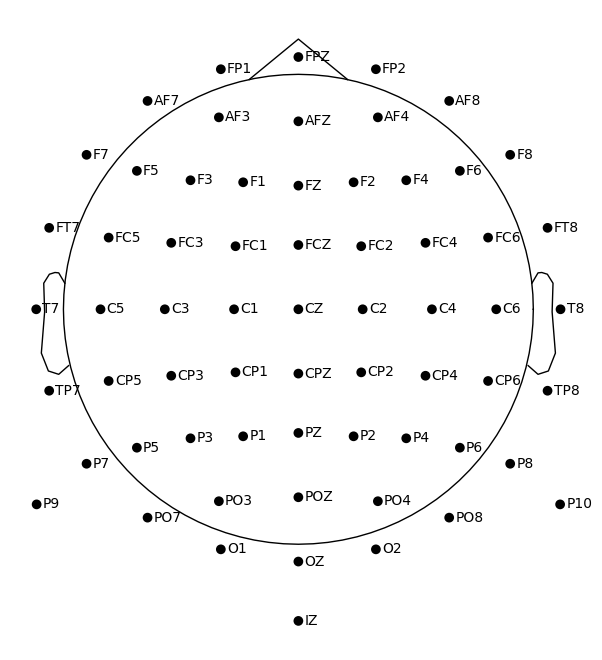

In [ ]:
sensor_pos = raw.plot_sensors(show_names=True)

# Part (a)

Used Annotations descriptions: ['origin']
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 206 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


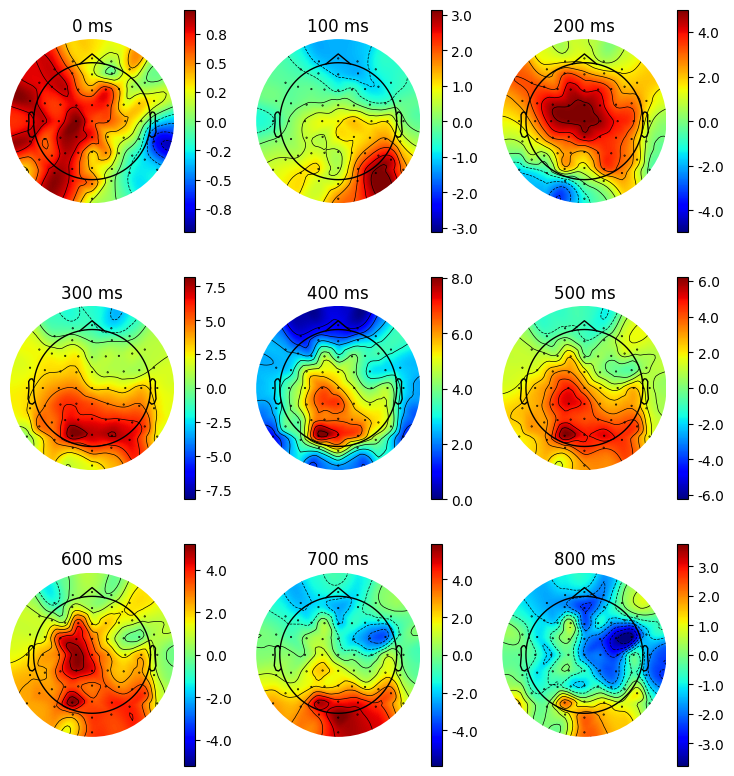

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt

events, event_id = mne.events_from_annotations(raw)
# Create Epochs start from sample 256(0ms) to 462(800ms)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=0.8, baseline=None, preload=True)

# Compute the ERP
erps = epochs.average()

times_20steps = [round(0.02 * i, 2) for i in range(41)]  # 0 to 800 ms in steps of 20 ms
time_100steps = times_20steps[::5][:9] # 0 to 800 ms in steps of 100 ms

avg_erps = []
for time in time_100steps:  # 0 to 800 ms in steps of 100 ms

    start = round(max(0, time - 0.02), 2)  # 20 ms before
    stop = round(min(0.8, time + 0.02), 2)  # 20 ms after

    # Getting the average data around the time point
    avg_data = erps.copy().crop(tmin=start, tmax=stop).data.mean(axis=1)
    avg_erps.append(avg_data)

# Make a numpy array from avg_erps
avg_erps = np.array(avg_erps)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.ravel()

# Plot the topomaps
for i, (erp, time) in enumerate(zip(avg_erps, time_100steps)):
    # Create a topomap at each time point with ch_type set to 'eeg'
    im, _ = mne.viz.plot_topomap(erp, erps.info, axes=axs[i], show=False, extrapolate='head', ch_type='eeg', cmap="jet", contours=10, sensors=True)
    # Adjust the color limits to reflect the global max and min
    # im.set_clim(-4, 4)
    fig.colorbar(im, ax=axs[i], format='%3.1f', orientation='vertical')
    # Adding title to each subplot
    axs[i].set_title(f'{time * 1000:.0f} ms')

# Display the plot
plt.show()

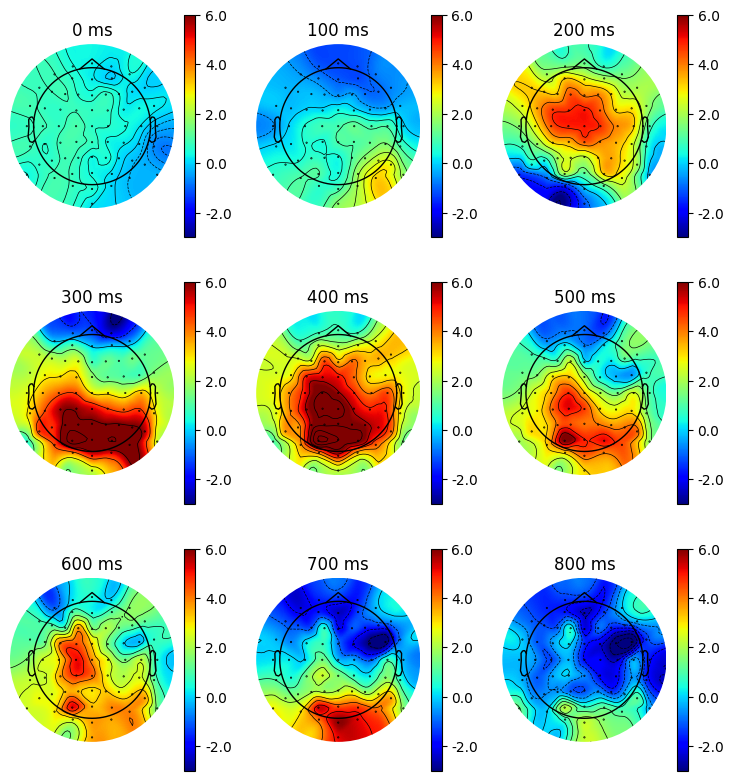

In [ ]:
'''
Here I set the colorbar range constant for all topomaps
'''

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.ravel()

# Plot the topomaps
for i, (erp, time) in enumerate(zip(avg_erps, time_100steps)):
    # Create a topomap at each time point with ch_type set to 'eeg'
    im, _ = mne.viz.plot_topomap(erp, erps.info, axes=axs[i], show=False, extrapolate='head', ch_type='eeg', cmap="jet", contours=10, sensors=True)
    # Adjust the color limits to reflect the global max and min
    im.set_clim(-3, 6)
    fig.colorbar(im, ax=axs[i], format='%3.1f', orientation='vertical')
    # Adding title to each subplot
    axs[i].set_title(f'{time * 1000:.0f} ms')

# Display the plot
plt.show()

# Part (b)

Used Annotations descriptions: ['origin']
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 180 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


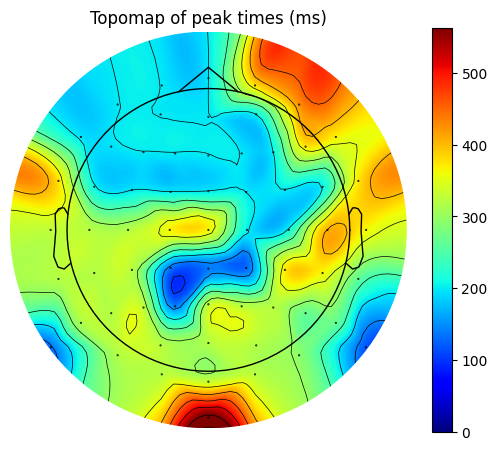

In [ ]:
import numpy as np
import mne
from matplotlib import pyplot as plt
import matplotlib.colorbar as mcolorbar
import matplotlib.colors as mcolors

# Create epochs from the annotations
events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id, tmin=0.1, tmax=0.8, baseline=None, preload=True)

# Compute the ERP and get the average over all trials
erps = epochs.average()

# Get the data and times arrays
data = erps.data
times = erps.times

# Find the indices of the times array corresponding to the 100ms and 800ms
start_idx = np.searchsorted(times, 0.1)
end_idx = np.searchsorted(times, 0.8)

# Find the time point of the peak activity within the specified window for each electrode
peak_times_idx = np.argmax(data[:, start_idx:end_idx], axis=1) + start_idx
peak_times_ms = times[peak_times_idx] * 1000  # Convert to milliseconds

# Plot topomap of peak times
fig, ax = plt.subplots()
# mne.viz.plot_topomap(peak_times_ms, erps.info, axes=ax, show=False)
im, cm = mne.viz.plot_topomap(peak_times_ms, erps.info, axes=ax, show=False, extrapolate='head', ch_type='eeg', cmap="jet", contours=10, sensors=True)
ax.set_title('Topomap of peak times (ms)')
# Create a custom colorbar norm
# norm = mcolors.Normalize(vmin=-400, vmax=400)
clb = fig.colorbar(im, cmap='jet')
# Display the plot
plt.show()


# Part (c)

In [ ]:
import numpy as np
# Define the radius range
radius_range = [0.18, 0.28]

# Get Cartesian coordinates (assuming elec_df contains the coordinates)
x = elec_df['X'].values
y = elec_df['Y'].values

# Initialize the Laplacian filtered data
laplacian_data = np.zeros_like(eeg_data_avg)

# Iterate over each electrode
for i in range(len(elec_df)):
    # Compute the distances to all other electrodes
    distances = np.sqrt((x - x[i]) ** 2 + (y - y[i]) ** 2)

    # Find the indices of the electrodes within the specified radius
    surrounding_indices = np.where((distances > radius_range[0]) & (distances < radius_range[1]))[0]

    # Compute the weights for surrounding electrodes
    if len(surrounding_indices) > 0:
        weights = 1 / distances[surrounding_indices]
        weights = weights / np.sum(weights)  # Normalize weights
    else:
        weights = np.array([])

    # Ensure weights are broadcasted correctly along the time axis
    weights = weights[:, np.newaxis]

    # Compute the Laplacian filtered signal for each time point
    if len(weights) > 0:
        laplacian_data[i, :] = eeg_data_avg[i, :] - np.sum(weights * eeg_data_avg[surrounding_indices, :], axis=0)
    else:
        laplacian_data[i, :] = eeg_data_avg[i, :]

# Create an mne object from laplacian data
laplacian_raw = raw.copy()
laplacian_raw._data = laplacian_data


Used Annotations descriptions: ['origin']
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 206 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


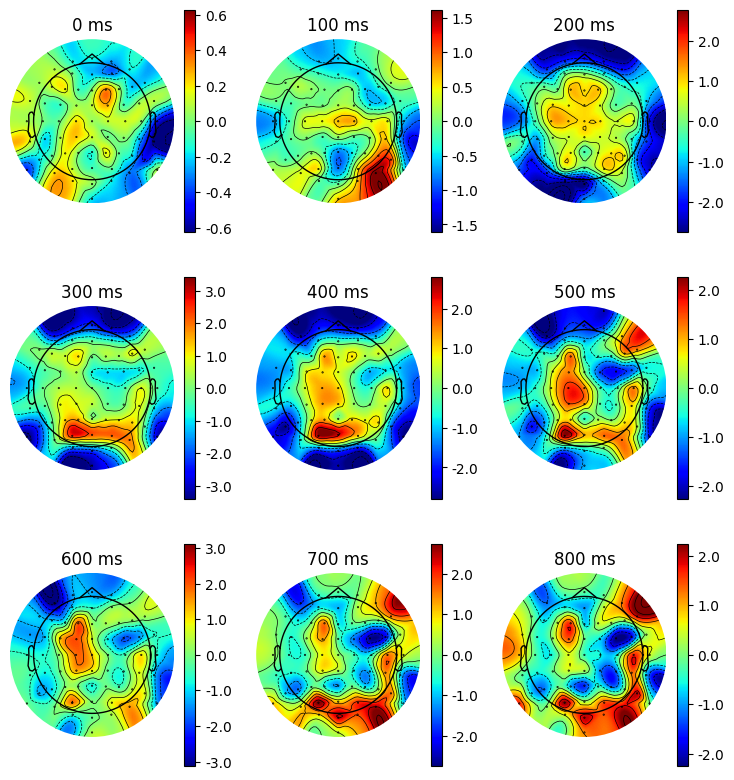

In [ ]:
# The Laplacian data should be converted to an Evoked object
events, event_id = mne.events_from_annotations(laplacian_raw)
epochs = mne.Epochs(laplacian_raw, events, event_id, tmin=0, tmax=0.8, baseline=None, preload=True)

# Compute the ERP
erps = epochs.average()

times_20steps = [round(0.02 * i, 2) for i in range(41)]  # 0 to 800 ms in steps of 20 ms
time_100steps = times_20steps[::5][:9] # 0 to 800 ms in steps of 100 ms

avg_erps = []
for time in time_100steps:  # 0 to 800 ms in steps of 100 ms

    start = round(max(0, time - 0.02), 2)  # 20 ms before
    stop = round(min(0.8, time + 0.02), 2)  # 20 ms after

    # Getting the average data around the time point
    avg_data = erps.copy().crop(tmin=start, tmax=stop).data.mean(axis=1)
    avg_erps.append(avg_data)

# Make a numpy array from avg_erps
avg_erps = np.array(avg_erps)

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.ravel()

# Plot the topomaps
for i, (erp, time) in enumerate(zip(avg_erps, time_100steps)):
    # Create a topomap at each time point with ch_type set to 'eeg'
    im, _ = mne.viz.plot_topomap(erp, erps.info, axes=axs[i], show=False, extrapolate='head', ch_type='eeg', cmap="jet", contours=10, sensors=True)
    # Adjust the color limits to reflect the global max and min
    # im.set_clim(-4, 4)
    fig.colorbar(im, ax=axs[i], format='%3.1f', orientation='vertical')
    # Adding title to each subplot
    axs[i].set_title(f'{time * 1000:.0f} ms')

# Display the plot
plt.show()

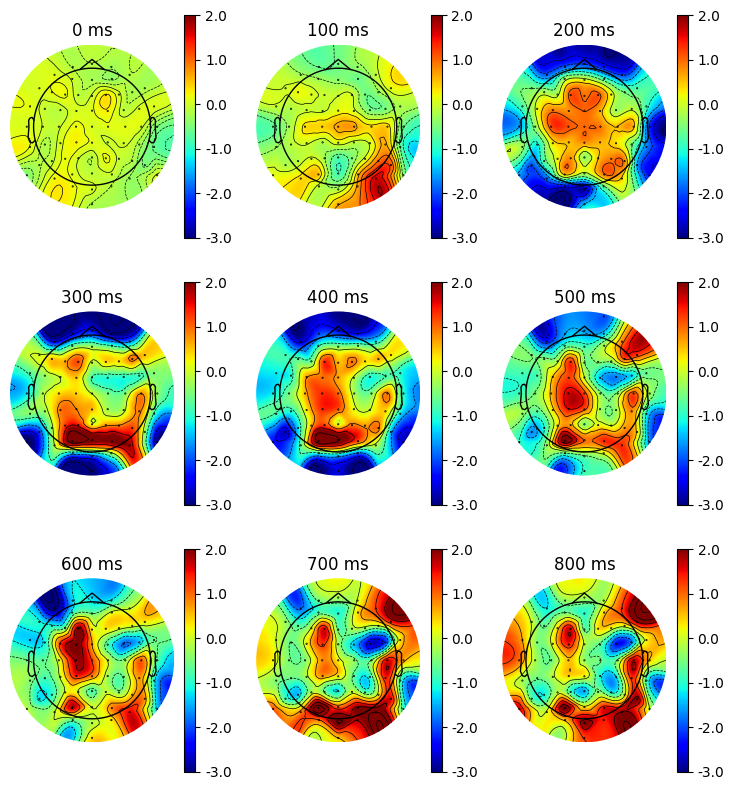

In [ ]:
'''
Here I set the colorbar range constant for all topomaps
'''

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.ravel()

# Plot the topomaps
for i, (erp, time) in enumerate(zip(avg_erps, time_100steps)):
    # Create a topomap at each time point with ch_type set to 'eeg'
    im, _ = mne.viz.plot_topomap(erp, erps.info, axes=axs[i], show=False, extrapolate='head', ch_type='eeg', cmap="jet", contours=10, sensors=True)
    # Adjust the color limits to reflect the global max and min
    im.set_clim(-3, 2)
    fig.colorbar(im, ax=axs[i], format='%3.1f', orientation='vertical')
    # Adding title to each subplot
    axs[i].set_title(f'{time * 1000:.0f} ms')

# Display the plot
plt.show()